In [1]:
cd /home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src

/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src


In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath("./post_processing/local_calculations"))
sys.path.insert(0, os.path.abspath("./helper_functions/cloud"))
sys.path.insert(0, os.path.abspath("./file_manager"))
sys.path.insert(0, os.path.abspath("./hamiltonian"))
sys.path.insert(0, os.path.abspath("./correlation"))
sys.path.insert(0, os.path.abspath("./single_and_double_excitations_subspace"))

In [3]:
from qutip import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from hamiltonian.hamiltonian_builder import *


from helper_functions.operators import *
from helper_functions.cloud import *
from file_manager.visualization_preparation_tools import *
from file_manager.file_saver import *

from correlation.second_order_correlation  import *
from single_and_double_excitations_subspace.parameter_generator_for_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_optimized_ODE import *

from single_and_double_excitations_subspace.QRT_dynamics_ODE import *

from post_processing.local_calculations import *
from helper_functions.cloud import *
from helper_functions.operators import *
from helper_functions.other import * 

from scipy.stats import gmean

In [4]:
plt.style.use('tableau-colorblind10')

In [65]:

N_atoms = N = 6
Omega = 0.1
Delta = 20
b0 = 1.5
def relative_error(A,B):
    return np.abs((A-B)/(A+B))

def get_array_of_runs(N, Omega, Delta, b0):
    description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo"

    results_path = "../results/"
    DefaultInfo = f"N{N}_Omega{Omega}_Delta{Delta}_"
    defaultangle, angle = "25_", "205"
    rho_ss_parameter = "_direct"


    label_folder = results_path+DefaultInfo+description + "/" # "_"+ defaultangle +angle+ "_"   + rho_ss_parameter + "/"
    paths_array = get_array_of_runs_dat_files(label_folder) #all runs for a given phi
    runs_txt = get_array_of_numpy_runs(paths_array, npy = True)
    
    return runs_txt

def get_errors(N, Omega, Delta, b0, number_of_simulations_to_consider = None, experimental_time = False):
    """get average error: avg(err1, err2, ..., errN) and 
       error of averages: <1-<g2_montecarlo>/<g2_exact>)>"""
    
    runs_txt = get_array_of_runs(N, Omega, Delta, b0)
    if experimental_time == True:
        runs_txt_n = np.zeros((len(runs_txt),len(runs_txt[0]), 50 ), dtype = "complex")
        for i in range(len(runs_txt)):
            for j in range(len(runs_txt[0])):
                runs_txt_n[i][j] =  runs_txt[i][j][:50]
        runs_txt = runs_txt_n

    relative_error_of_each_simulation = []
    relative_error_of_each_simulation_single_excitation = []
    
    if number_of_simulations_to_consider is None:
        number_of_simulations_to_consider = len(runs_txt)
    for l in range(0,number_of_simulations_to_consider):
        try:
            avg_relative_error = relative_error(runs_txt[l][0], runs_txt[l][1])
            relative_error_of_each_simulation.append(avg_relative_error)
            
            avg_relative_error_single_excitation = np.average(relative_error(np.real(runs_txt[l])[2], np.real(runs_txt[l][1])))
            relative_error_of_each_simulation_single_excitation.append(avg_relative_error_single_excitation)

        except:
            break
    
    avg_relative_error_full = np.average(relative_error(np.average(runs_txt, axis = 0)[0], np.average(runs_txt, axis = 0)[1]))

    return np.average(relative_error_of_each_simulation), avg_relative_error_full, np.average(relative_error_of_each_simulation_single_excitation), avg_relative_error_single_excitation, number_of_simulations_to_consider

    

In [27]:
get_errors(N=6, Omega=6, Delta=20, b0=0.1)

(0.1588785205900768,
 0.13162363403707877,
 0.35703255484663454,
 0.35977295592817476,
 20)

In [70]:
b0_s = [0.1, 1, 2, 3, 5, 7]
Omega_s = [0.1, 0.5, 2, 6]
errors = np.zeros([len(b0_s), len(Omega_s), 5])

number_of_simulations_to_consider = 20

Delta = 20
N = 6

for i in range(len(b0_s)):
    for j in range(len(Omega_s)):
        b0 = b0_s[i]
        Omega = Omega_s[j]
        try:
            errors[i][j] =  [*get_errors(N, Omega, Delta, b0, number_of_simulations_to_consider, experimental_time=False)]
        except:
            print(f"b0={b0} and Omega= {Omega} is not available")
            

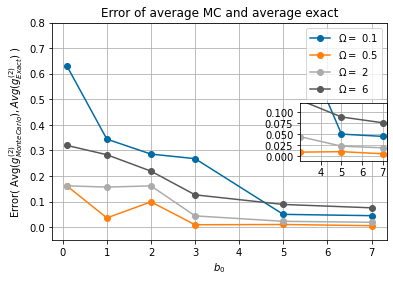

In [67]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.70, 0.4, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])


ax1.set_title("Error of average MC and average exact")


ax1.grid("True")

ax1.set_ylim(-0.05,0.8)

ax2.set_xlim(3,7.2)

ax2.set_yticks([0,0.025,0.05,0.075, 0.10,0.15,0.20])
ax2.set_xticks([4,5,6,7])

ax2.grid(True)

#ax1.plot(0,0,"-o", label = "Omega = 0.1", alpha = 0)
for i in range(0,len(Omega_s)):
    ax1.plot(b0_s, errors[:,i,1], "-o", label = r"$\Omega =$ "+f"{Omega_s[i]}")
    #ax1.plot(b0_s, errors[:,i,1+2], "*", color=ax1.lines[-1].get_color())


for i in range(0,len(Omega_s)):
    ax2.plot(b0_s, errors[:,i,1], "-o")
    #ax2.plot(b0_s, errors[:,i,1+2], "-*", color=ax2.lines[-1].get_color())

    
ax2.set_ylim(-0.01,0.12)

    
ax1.set_xlabel("$b_0$")
ax1.set_ylabel("Error( Avg($g^{(2)}_{MonteCarlo}) , Avg(g^{(2)}_{Exact}$) )" )

ax1.legend()
#ax2.legend(bbox_to_anchor=(0.49, 2.3))

plt.savefig(f"./benchmarking/Error_of_avg_qutip_vs_MC_against_b0_with_single_excitation.png", dpi = 300)


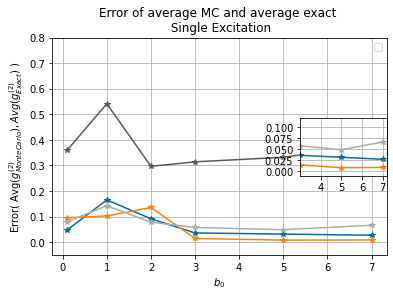

In [39]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.70, 0.4, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])


ax1.set_title("Error of average MC and average exact \n Single Excitation")


ax1.grid("True")

ax1.set_ylim(-0.05,0.8)

ax2.set_xlim(3,7.2)

ax2.set_yticks([0,0.025,0.05,0.075, 0.10,0.15,0.20])
ax2.set_xticks([4,5,6,7])

ax2.grid(True)

#ax1.plot(0,0,"-o", label = "Omega = 0.1", alpha = 0)
for i in range(0,len(Omega_s)):
    #ax1.plot(b0_s, errors[:,i,1], "-o", label = r"$\Omega =$ "+f"{Omega_s[i]}")
    ax1.plot(b0_s, errors[:,i,1+2], "-*")


for i in range(0,len(Omega_s)):
    #ax2.plot(b0_s, errors[:,i,1], "-o")
    ax2.plot(b0_s, errors[:,i,1+2], "-*")

    
ax2.set_ylim(-0.01,0.12)

    
ax1.set_xlabel("$b_0$")
ax1.set_ylabel("Error( Avg($g^{(2)}_{MonteCarlo}) , Avg(g^{(2)}_{Exact}$) )" )

ax1.legend()
#ax2.legend(bbox_to_anchor=(0.49, 2.3))

plt.savefig(f"./benchmarking/Error_of_avg_qutip_vs_MC_against_b0_with_single_excitation.png", dpi = 300)


In [51]:
plt.subplots?

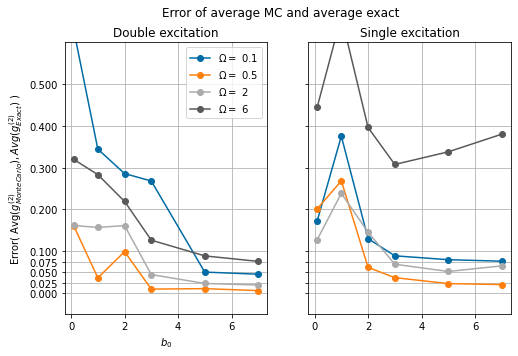

In [71]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize= (8,5), sharey = True)


plt.suptitle("Error of average MC and average exact")


ax1.grid("True")

ax1.set_ylim(-0.05,0.6)

ax2.set_yticks([0,0.025,0.05,0.075, 0.10,0.20, 0.3, 0.4, 0.5])

#ax2.set_xlim(3,7.2)

#ax2.set_xticks([4,5,6,7])

ax2.grid(True)

#ax1.plot(0,0,"-o", label = "Omega = 0.1", alpha = 0)

ax1.set_title("Double excitation")
for i in range(0,len(Omega_s)):
    ax1.plot(b0_s, errors[:,i,1], "-o", label = r"$\Omega =$ "+f"{Omega_s[i]}")
    #ax1.plot(b0_s, errors[:,i,1+2], "-o")

ax2.set_title("Single excitation")
for i in range(0,len(Omega_s)):
    #ax2.plot(b0_s, errors[:,i,1], "-o")
    ax2.plot(b0_s, errors[:,i,1+2], "-o")

    
#ax2.set_ylim(-0.01,0.12)

    
ax1.set_xlabel("$b_0$")
ax1.set_ylabel("Error( Avg($g^{(2)}_{MonteCarlo}) , Avg(g^{(2)}_{Exact}$) )" )

ax1.legend()
#ax2.legend(bbox_to_anchor=(0.49, 2.3))

plt.savefig(f"./benchmarking/Error_of_avg_qutip_vs_MC_against_b0_with_single_excitation.png", dpi = 300)


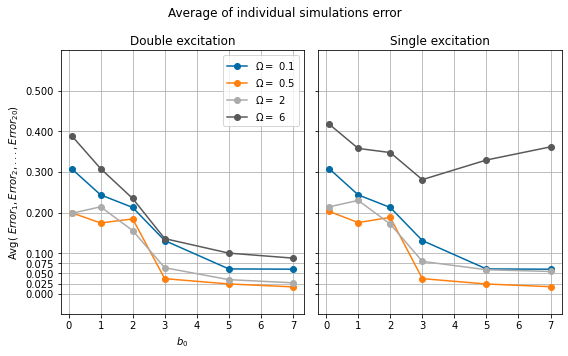

In [72]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize= (8,5), sharey = True)

# These are in unitless percentages of the figure size. (0,0 is bottom left)



plt.suptitle("Average of individual simulations error")


ax1.grid("True")

ax1.set_ylim(-0.05,0.6)

ax2.set_yticks([0,0.025,0.05,0.075, 0.10,0.20, 0.3, 0.4, 0.5])

#ax2.set_xlim(3,7.2)

#ax2.set_xticks([4,5,6,7])

ax2.grid(True)

#ax1.plot(0,0,"-o", label = "Omega = 0.1", alpha = 0)

ax1.set_title("Double excitation")
for i in range(0,len(Omega_s)):
    ax1.plot(b0_s, errors[:,i,0], "-o", label = r"$\Omega =$ "+f"{Omega_s[i]}")
    #ax1.plot(b0_s, errors[:,i,1+2], "-o")

ax2.set_title("Single excitation")
for i in range(0,len(Omega_s)):
    #ax2.plot(b0_s, errors[:,i,1], "-o")
    ax2.plot(b0_s, errors[:,i,0+2], "-o")
    
ax1.set_xlabel("$b_0$")
ax1.set_ylabel("Avg( $Error_1, Error_2, ..., Error_{"+str(number_of_simulations_to_consider)+"})$" )

ax1.legend()
#ax2.legend(bbox_to_anchor=(0.49, 2.3))

plt.savefig(f"./benchmarking/avg_of_individual_errors_against_b0.png", dpi = 300)

plt.tight_layout()

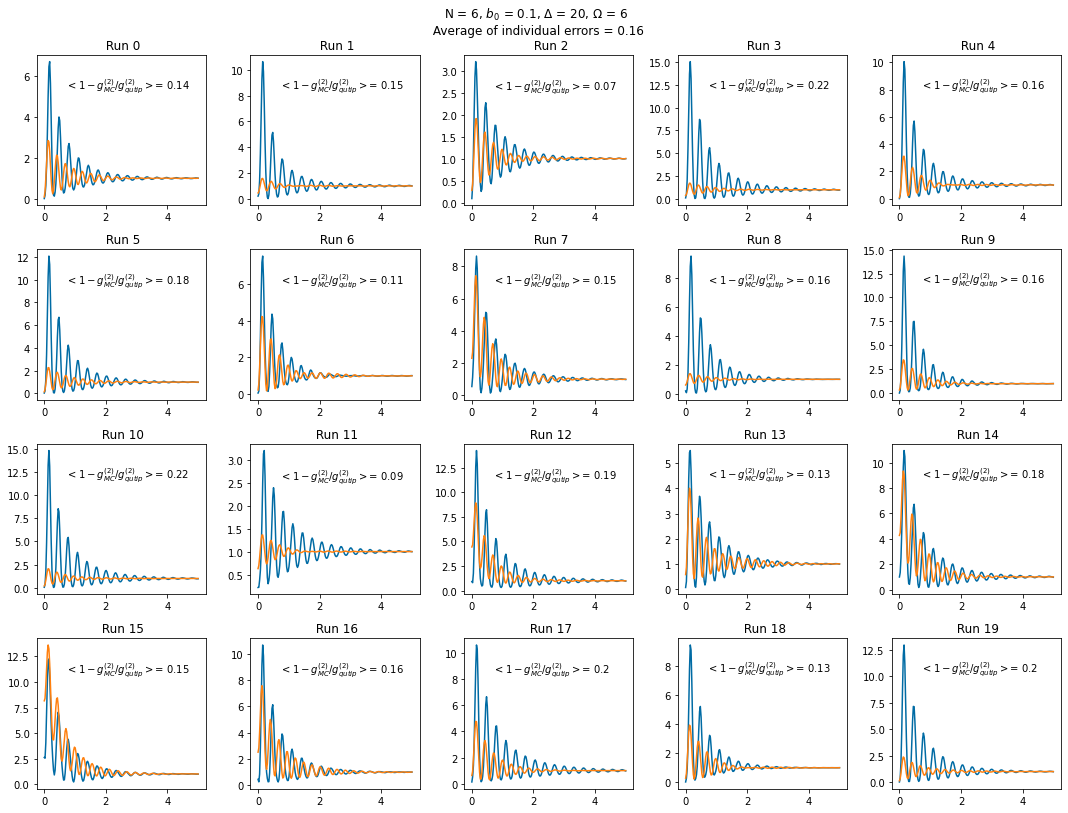

In [11]:
N_atoms = N = 6
Omega = 6
Delta = 20
b0 = 0.1

runs_txt = get_array_of_runs(N, Omega, Delta, b0)


fig = plt.figure(figsize = (15,14))


tf = 5
taulist, dt = np.linspace(0,tf,200, retstep = True)  
    
    
rows = 5
columns = 5
initial = 0

indexes_to_plot = list(range(initial, initial + rows*columns+1,1))


relative_error_of_each_simulation = []
for j in range(0,rows*columns):
    

    
    l = indexes_to_plot[j]
    try:
        avg_relative_error = np.average(relative_error(np.real(runs_txt[l])[0], np.real(runs_txt[l][1])))
        relative_error_of_each_simulation.append(avg_relative_error)
    except:
        break
    #plt.title(f" Run {l}:"+ r"$<1-g^{(2)}_{MC}/g^{(2)}_{qutip}>$"+ f"= {np.round(avg_relative_error, 2)}. ", loc = "left") 
    plt.subplot(rows, columns, j+1)
    
    plt.title(f" Run {l}")
    
    plt.plot( taulist, np.real(runs_txt[l][0]))
    plt.plot( taulist, np.real(runs_txt[l][1]))
    plt.text(0.7, np.max(np.real(runs_txt[l][:]))*0.80, r"$<1-g^{(2)}_{MC}/g^{(2)}_{qutip}>$"+ f"= {np.round(avg_relative_error, 2)}" )

plt.suptitle(f"N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega} \n Average of individual errors = {np.round(np.average(relative_error_of_each_simulation), 2)}")
plt.tight_layout()
plt.savefig(f"./benchmarking/N{N}_Omega{Omega}_Delta_{Delta}_b0_{b0}_g2_qutip_vs_MC_avg_error_{rows}x{columns}.png", dpi = 300)

/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


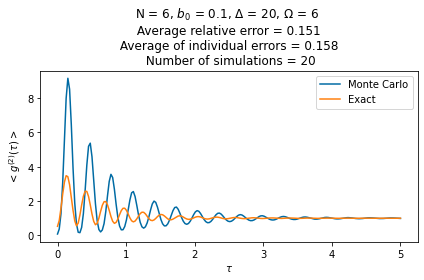

In [12]:
plt.plot( taulist, gmean(runs_txt, axis = 0)[0], label = "Monte Carlo")
plt.plot( taulist, gmean(runs_txt, axis = 0)[1], label = "Exact")

avg_relative_error = np.average(relative_error(gmean(runs_txt, axis = 0)[0], gmean(runs_txt, axis = 0)[1]))
                                        
plt.title(f"N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega}  \n Average relative error = {np.round(avg_relative_error, 3)} \n Average of individual errors = {np.round(np.average(relative_error_of_each_simulation), 3)} \n Number of simulations = {len(runs_txt)}")
plt.xlabel(r"$\tau$ ")
plt.ylabel(r"$ <g^{(2)}(\tau)>  $")


plt.legend()

plt.tight_layout()
plt.savefig(f"./benchmarking/N{N}_Omega{Omega}_Delta_{Delta}_b0_{b0}_g2_qutip_vs_MC_avg_error_averages.png", dpi = 300)